# Classification

## MNIST

This chapter we will use the MNIST dataset which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau.

In [1]:
# fetching MNIST data
from sklearn.datasets import fetch_openml
mist = fetch_openml('mnist_784', version=1)
mist.keys()

c:\Users\streh\OneDrive\Desktop\Hands-On-Machine-Learning\I. The Fundamentals of Machine Learning\env\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Looking at the shape of the data

In [2]:
mnist = mist
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

There are 70,000 images and each image has 784 features. This is because each image is 28x28 pixels, and each feature simply represents one pixel's intensity, from 0 (white) to 255 (black). Let's take a peek at one digit from the dataset. All you need to do is grab an instance's feature vector, reshape it to a 28x28 array, and display it using Matplotlib's `imshow()` function:

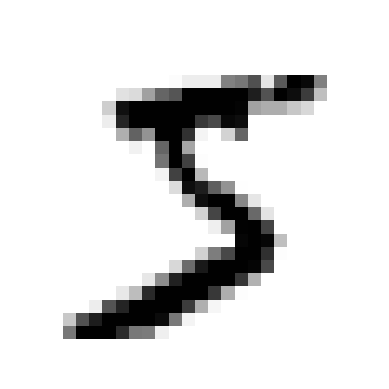

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

some_digit = np.array(X)[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

This looks like a 5, and indeed that's what the label tells us

In [6]:
y[0]

'5'

Note that the label is a string. We prefer numbers, so let's cast y to integers:

In [7]:
y = y.astype(np.uint8)

Before starting however, you should always create a test set and set it aside before inspecting the data closely

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled for us, which is good as this guarantees that all cross-validation folds will be similar (you don't want one fold to be missing some digits). Some learning algorithms are sensitive to the order of the training isntances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won't happen.

## Training a Binary Classifier

Let's simplify for now and only try to identify one digit -- for example, the number 5. This "5-detector" will be an example of a *binary classifier*, capable of distinguishing between just two classes, 5 and not-5. Let's create the target vectors for this classification task

In [9]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

Now we can pick a classifier and train it, we can start with a *Stochastic Gradient Descent (SGD)* classifier using the `SGDClassifier` class. This one is generally good for handling very large datasets efficiently. This is in part because SGD deals with training instances independently.

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now you can use it to detect images of the number 5

In [11]:
sgd_clf.predict([some_digit])

c:\Users\streh\OneDrive\Desktop\Hands-On-Machine-Learning\I. The Fundamentals of Machine Learning\env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

We implement cross-validation typically by doing more than what Scikit-learn will provide off-the-shelf which is pretty straightforward.

The following does the same thing as Scikit-Learn's `cross_val_score()` function, and prints the same result

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,) # random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]  # Use iloc to index by position
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.95035
0.96035
0.9604


The `StratifiedKFold` class performs stratified sampling to produce folds that contain a representative ratio of each class. 

At each iteration, the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ration of correct predictions.

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

This score is good but we need to look at a very dumb classifier to see how it compares

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

This is because only 10% of the images are 5's so if you guess that an image is *not* a 5, you will be right 90% of the time.

### Confusion Matrix

A much better way to evaluate is through the confusion matrix.

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [18]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Precision and Recall

Scikit-Learn provides several functions to compute classifier metrics, including precision and recall:

In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred) # 4096 / (4096 + 1325)

0.6511713705958311

$F_1$ is a good way to account for both precision and recall through the following formula:

$$ F_1 = \frac{2}{ \frac{1}{precision} + \frac{1}{recall} } = 2 \times \frac{precision \times recall}{precision + recall} = \frac{TP}{TP + \frac{FN+FP}{2}} $$

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/Recall Tradeoff

Use the `SGDClassifier` to understand the tradeoff

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

c:\Users\streh\OneDrive\Desktop\Hands-On-Machine-Learning\I. The Fundamentals of Machine Learning\env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

The `SGDClassifier` uses a threshold equal to 0, so the previous code returns the same result as the `predict()` method. Let's raise the threshold

In [24]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Now the image is a 5 but the classifier deems it not when the threshold is increased.

Use the `cross_val_predict()` function to find what threshold to use.

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Now with these scores you can compute precision and recall for all possible thresholds using the `precision_recall_curve()` function

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finall plot the precision and recall as functions of the threshold value using matplotlib

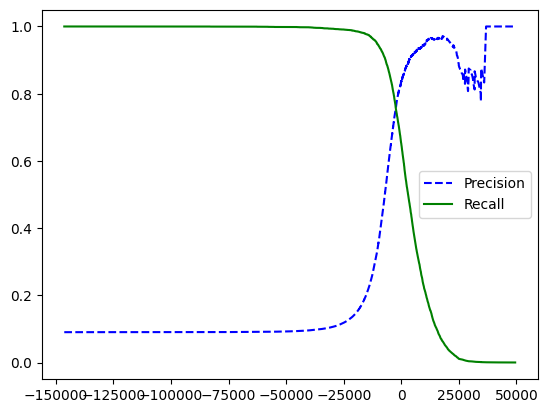

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()
 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

The precision curve is a little bumpier because the precision may sometimes go down when you raise the threshold - but in general it will go up.

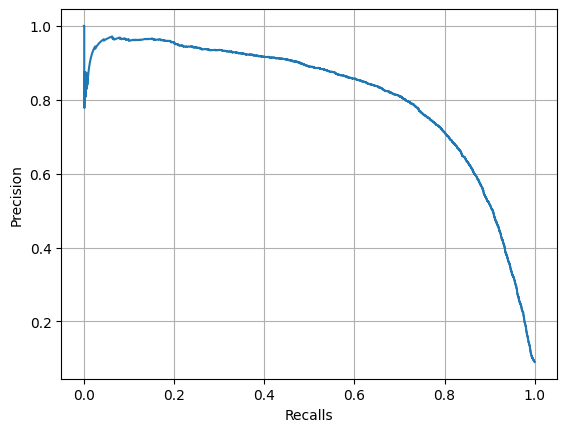

In [28]:
plt.plot(recalls, precisions)
plt.xlabel('Recalls')
plt.ylabel('Precision')
plt.grid()
plt.show()

You can see the precision starts to fall sharply around 80% recall.

Let's say you aim for 90% precision, you look up the first plot and find that you need a threshold of about 8,000. To be more precise you can search for the lowest threshold that gives you at least 90% precision (`np.argmax()` will give us the first index of the maximum value, which in this case means the first `True` value):

In [29]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [30]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [31]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [32]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### The ROC Curve

The receiver operating characterstic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the *true positive rate* (another name for recall) against the *false positive rate*. The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the *true negative rate*, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called *specificity*. Hence the ROC curve plots *sensitivity* (recall) versus 1 - *specificity*.

In [33]:
from sklearn.metrics import roc_curve 

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

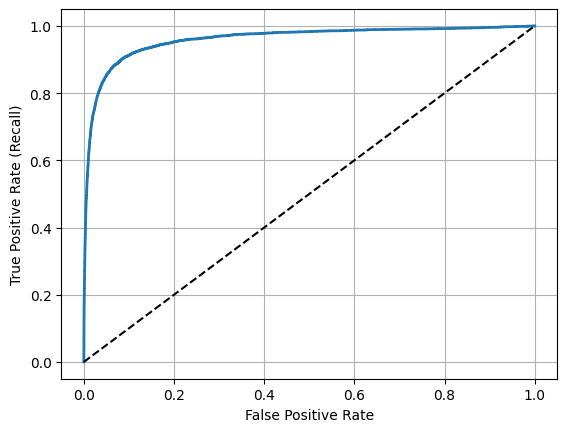

In [34]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') # dashed diagonal
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlabel('False Positive Rate')
    plt.grid()


plot_roc_curve(fpr, tpr)
plt.show()

Now make the roc auc score

In [35]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

To test on the `RandomForestClassifier` and see the ROC curve and the ROC AUC score compared to the `SGDClassifier`. First you need to get scores for each instance in the training set. But due to the way it works, the `RandomForestClassifier` class does not have a `decision_function()` method. Instead it has a `predict_proba()` method. Scikit-Learn classifiers generally have one or the other. The `predict_proba()` method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class (e.g., 70% chance that the image represents a 5)

In [36]:
from sklearn.ensemble import RandomForestClassifier 

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

But to put on a ROC curve, you need scores. Use the class's probability as the score.

In [37]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Now you can plot.

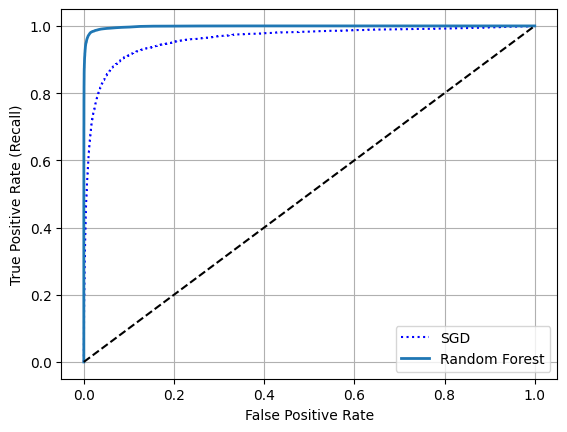

In [38]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

Random forest wins.

In [39]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classification

One way to make a multiclass classifier is to make 10 binary classifiers (for trying to apply to 10 digits). Then when you want to classify and image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. THis is called the *one-versus-all* (OvA) strategy (also called *one-versus-the-rest*).

Another approach is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another for 0s and 2s, another for 1s and 2s, and so on. Then, if there are $N$ classes, you need to train $N \times (N - 1) / 2$ classifiers. For the MNIST problem, this means training 45 binary classifiers.

For most binary classification algoriths, OvA is preferred.

In [40]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

c:\Users\streh\OneDrive\Desktop\Hands-On-Machine-Learning\I. The Fundamentals of Machine Learning\env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

This code trains the `SGDClassifier` on the training set using the original target classes from 0 to 9 instead of the 5-versus-all target classes. Under the hood, Scikit-Learn actually trained 10 binary classifiers, got their decision scores, and selected the class with the highest score. 

In [41]:
# showing the 10 scores
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

c:\Users\streh\OneDrive\Desktop\Hands-On-Machine-Learning\I. The Fundamentals of Machine Learning\env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [42]:
np.argmax(some_digit_scores)
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [43]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

c:\Users\streh\OneDrive\Desktop\Hands-On-Machine-Learning\I. The Fundamentals of Machine Learning\env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but OneVsOneClassifier was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [44]:
len(ovo_clf.estimators_)

45

Training a random forest is just as easy

In [45]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

c:\Users\streh\OneDrive\Desktop\Hands-On-Machine-Learning\I. The Fundamentals of Machine Learning\env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [46]:
forest_clf.predict_proba([some_digit])

c:\Users\streh\OneDrive\Desktop\Hands-On-Machine-Learning\I. The Fundamentals of Machine Learning\env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [47]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

Using a confusion matrix

In [52]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=2)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx


c:\Users\streh\OneDrive\Desktop\Hands-On-Machine-Learning\I. The Fundamentals of Machine Learning\env\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([[5601,    0,   26,    7,   11,   53,   39,    6,  179,    1],
       [   0, 6427,   45,   21,    4,   48,    4,   11,  171,   11],
       [  31,   32, 5279,   90,   65,   25,   74,   46,  303,   13],
       [  29,   24,  125, 5238,    2,  224,   26,   45,  337,   81],
       [  15,   14,   52,   12, 5246,   10,   39,   24,  262,  168],
       [  33,   17,   32,  173,   50, 4486,   79,   23,  452,   76],
       [  29,   19,   46,    2,   48,   95, 5560,    5,  113,    1],
       [  18,   12,   58,   27,   53,    9,    4, 5731,  130,  223],
       [  19,   67,   57,   82,    4,  122,   31,   10, 5395,   64],
       [  22,   17,   36,   62,  133,   28,    1,  182,  287, 5181]],
      dtype=int64)

Can be easier with the image representation

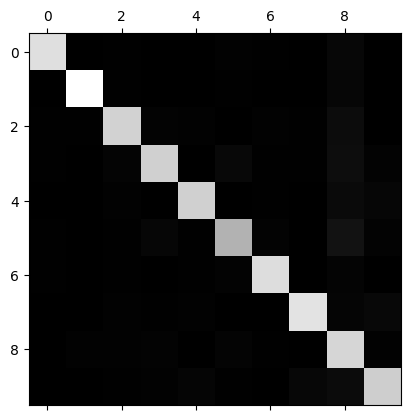

In [53]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Instead of absolute errors you can use the compare error rate

In [54]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

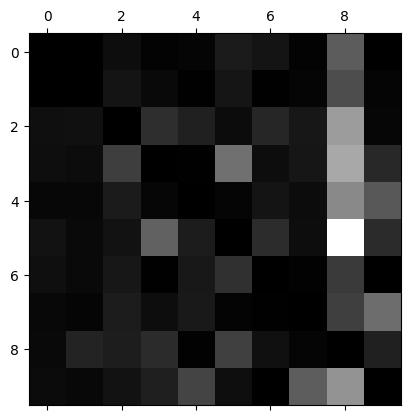

In [55]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Now you can clearly see the kinds of errors the classifier marks. Remember that rows represent actual classes, while columns represent predicted classes. The column for class 8 is bright which tells you that many images get misclassified as 8s.


Now let's plot examples of 3s and 5s using Matplotlib's `imshow()` function.

In [67]:
import matplotlib

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

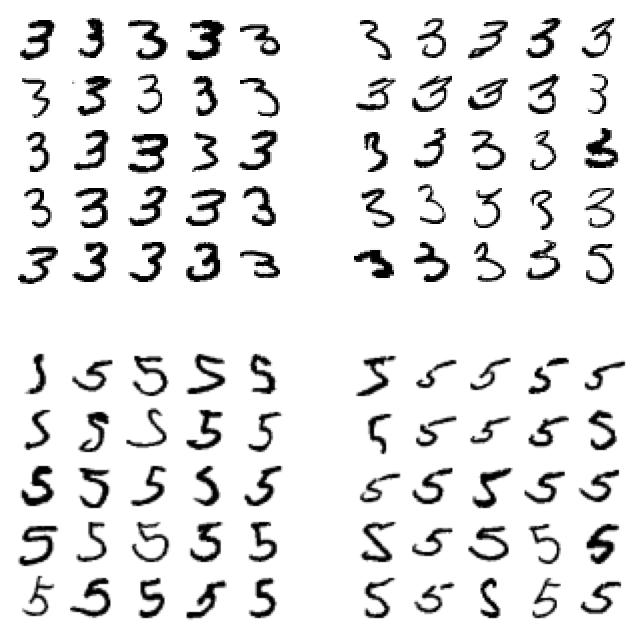

In [71]:
cl_a, cl_b = 3, 5
X_aa = np.array(X_train[(y_train == cl_a) & (y_train_pred == cl_a)])
X_ab = np.array(X_train[(y_train == cl_a) & (y_train_pred == cl_b)])
X_ba = np.array(X_train[(y_train == cl_b) & (y_train_pred == cl_a)])
X_bb = np.array(X_train[(y_train == cl_b) & (y_train_pred == cl_b)])

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

The two 5x5 blocks on the left how digits classified as 3s, and the two 5x5 blocks on the right show images classified as 5s.

Here we used a simple `SGDClassifier` which is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. So since 3s and 5s differ only by a few pixels, this model will easily confuse them.

## Multilabel Classification

Until now each instance has always been assigned to just one class. In some cases you may want your classifier to output multiple classes for each instance. 

Let's look at an example.

In [72]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

This code creates a y_multilabel array containing two target labels for each digit image: the first indicates whether or not the digit is large (7, 8, or 9) and the second indicates whether or not it is odd.

The next lines create a `KNeighborsClassifier` instance and we train it using the multiple targets array.

In [73]:
knn_clf.predict([some_digit])

c:\Users\streh\OneDrive\Desktop\Hands-On-Machine-Learning\I. The Fundamentals of Machine Learning\env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

This code computes the average F1 score across all labels

In [74]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

This assumes that all labels are equally important, which may not be the case.

## Multioutput Classification

The last type of classification is called *multioutput classification*. It is a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

To illustrate, we'll build a system that removes noise from images. Let's start by adding noise 

In [75]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test